In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
palette = 'colorblind'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)

import theano.tensor as tt
import theano.tensor.slinalg as slinalg

In [2]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']

Text(0, 0.5, '$f(x)$')

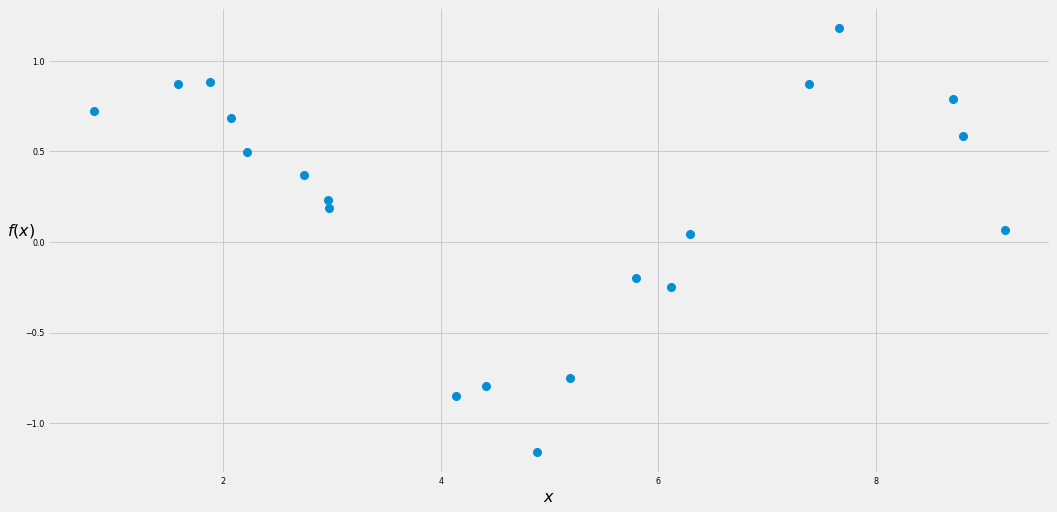

In [3]:
np.random.seed(5)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

In [4]:
def kernel(a, b, kernel_name='squared_exponential'):

    def squared_exponential(a, b):
        """Squared exponential kernel 
    
        """
        D = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
        return eta * np.exp(- rho * D)

    def periodic(a, b):
        """periodic kernel
    
        """
        a = np.sin(a)
        b = np.sin(b)
        D = np.sum(a**2, axis=1, keepdims=True) + np.sum(b**2, axis=1) - 2 * np.dot(a, b.T)
        return eta * np.exp(- rho * D)
   
    if kernel_name == 'squared_exponential':
        return squared_exponential(a, b)
    elif kernel_name == 'periodic':
        return periodic(a, b)

In [5]:
N = len(x)
# Sample points we should have at least 2d data
X = np.atleast_2d(x).T
# test points
Xtest = np.linspace(0, 10, 100).reshape(-1,1)

In [7]:
with pm.Model() as GP:

    mu = np.zeros(len(x))
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
   
    kernel_name = 'squared_exponential'
    K = kernel(X, X, kernel_name)
    cov = K + sigma * tt.eye(N)

    obs = pm.MvNormal('obs', mu, cov=cov, observed=y)
    

    # compute the mean at our test points.    
    L = slinalg.cholesky(cov)
    alpha = slinalg.solve(L.T, slinalg.solve(L, y))
    Ko = kernel(X, Xtest, kernel_name)
    mu_post = pm.Deterministic('mu_post', tt.dot(Ko.T, alpha))
    
    # compute the standard deviation at our test points.
    Koo = kernel(Xtest, Xtest, kernel_name)
    v = slinalg.solve(L, Ko)
    sigma_post = pm.Deterministic('sigma_post', tt.diag((Koo - tt.dot(v.T, v))**0.5))
    
    start = pm.find_MAP()
    trace = pm.sample(1000, step=pm.Metropolis(), start=start, random_seed=1)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -8.3982, ||grad|| = 0.15177: 100%|██████████| 26/26 [00:00<00:00, 301.32it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [rho]
>Metropolis: [eta]
Sampling 2 chains: 100%|██████████| 3

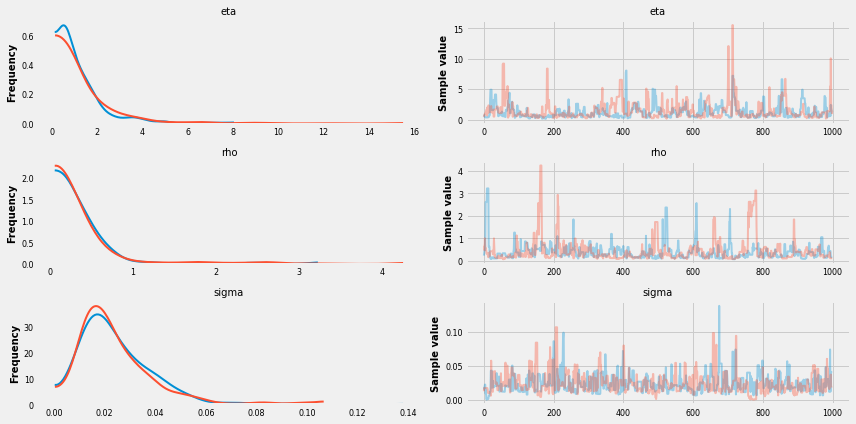

In [8]:
varnames = ['eta', 'rho', 'sigma']
pm.traceplot(trace, varnames);

In [9]:
pm.df_summary(trace, varnames)

AttributeError: module 'pymc3' has no attribute 'df_summary'

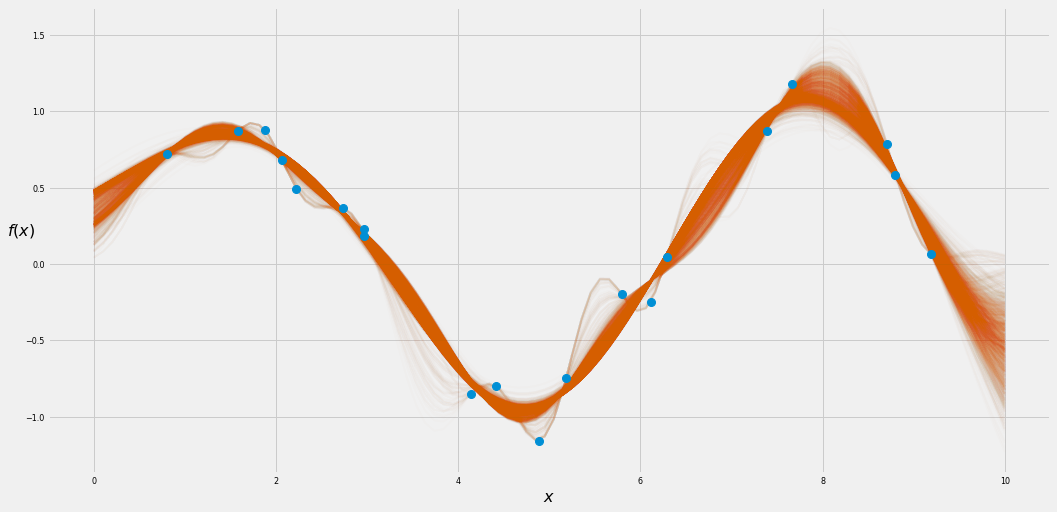

In [12]:
m = trace['mu_post']

plt.plot(Xtest, m.T, 'r', alpha=0.01)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

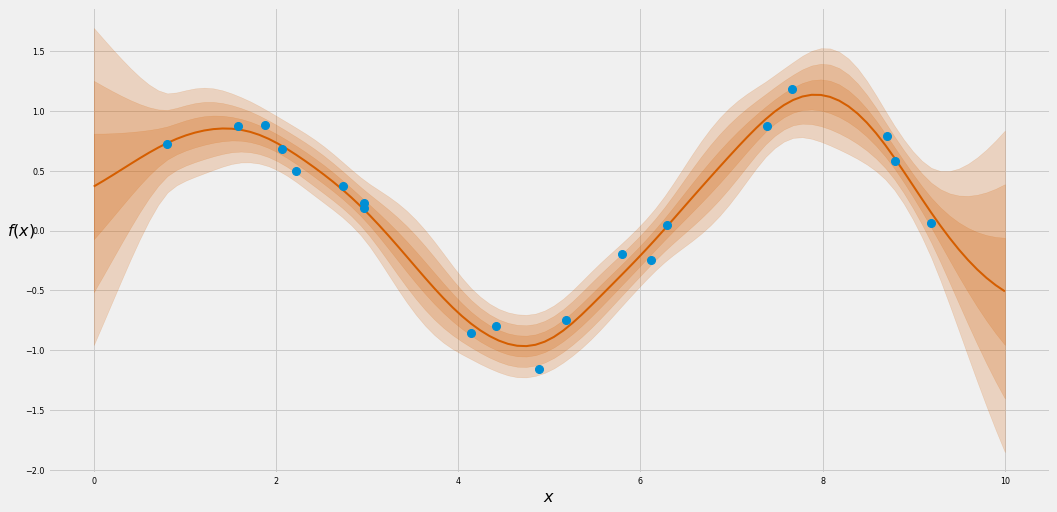

In [13]:
m = trace['mu_post'].mean(0)
s = trace['sigma_post'].mean(0)

for i in range(1, 4):
    plt.fill_between(Xtest.flat, m - i * s, m + i * s, color="r", alpha=0.2)


plt.plot(Xtest, m, 'r', lw=2)
plt.plot(Xtest, m.T, 'r', alpha=0.01)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

In [14]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer x86_64 running   and using:
Python 3.6.8
IPython 6.2.1
PyMC3 3.6
NumPy 1.15.4
Matplotlib 3.0.2
Seaborn 0.9.0

